# Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy

import sklearn
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
import os
import copy
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch.utils.data import TensorDataset

from scipy.linalg import expm
from numpy.linalg import norm


In [ ]:
def make_sparse_coded_signal1(n_samples, *, n_components, n_features,
                             n_nonzero_coefs, random_state=None):
    """Generate a signal as a sparse combination of dictionary elements.
    Returns a matrix Y = DX, such as D is (n_features, n_components),
    X is (n_components, n_samples) and each column of X has exactly
    n_nonzero_coefs non-zero elements.
    Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    n_components : int
        Number of components in the dictionary
    n_features : int
        Number of features of the dataset to generate
    n_nonzero_coefs : int
        Number of active (non-zero) coefficients in each sample
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    data : ndarray of shape (n_features, n_samples)
        The encoded signal (Y).
    dictionary : ndarray of shape (n_features, n_components)
        The dictionary with normalized components (D).
    code : ndarray of shape (n_components, n_samples)
        The sparse code such that each column of this matrix has exactly
        n_nonzero_coefs non-zero items (X).
    """
    generator = check_random_state(random_state)

    # generate dictionary
    D = generator.randn(n_features, n_components)
    D /= np.sqrt(np.sum((D ** 2), axis=0)) 

    # generate code
    X = np.zeros((n_components, n_samples))
    for i in range(n_samples):
        idx = np.arange(n_components)
        generator.shuffle(idx)
        idx = idx[:n_nonzero_coefs]
        X[idx, i] = generator.randn(n_nonzero_coefs)

    # encode signal
    Y = np.dot(D, X)

    return map(np.squeeze, (Y, D, X))


In [ ]:
################# params #########################
n_nonzero_coefs=10
n_comp=15
n_samples=100
input_dim=20
#####################################################

X, dictionary, code = make_sparse_coded_signal(
n_samples=n_samples, n_components=n_comp, n_features=input_dim, \
n_nonzero_coefs=n_nonzero_coefs,random_state=42,

)


In [ ]:
print(np.linalg.norm(X-dictionary.dot(code)))

temp = np.random.randn(dictionary.shape[0], dictionary.shape[1])
print(np.linalg.norm(X-temp.dot(code)))


0.0
150.1756875681782


In [ ]:
print(X.shape)
print(dictionary.shape)
print(code.shape)

(20, 100)
(20, 5000)
(5000, 100)


In [ ]:
############ Dictionary learning ##############
##alpha=1 (regularization parameter)
dict_learner = DictionaryLearning(n_components=n_comp, transform_algorithm='lasso_lars'\
                                  , random_state=42,)
X_transformed = dict_learner.fit_transform(X)


X_hat = X_transformed @ dict_learner.components_
print( np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)) )

#print( X_transformed.shape )
#print( np.linalg.norm(X_transformed-dictionary)/np.linalg.norm(dictionary) )

0.0172155483915303


# Feeding into autoencoder

In [ ]:
BatchSize = 100
trainset=X

my_x=list(X.reshape(n_samples,input_dim,-1))
tensor_x = torch.Tensor(my_x) # transform to torch tensor
#tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x) # create your datset
#trainloader = DataLoader(my_dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                         shuffle=True, num_workers=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


In [ ]:
import torch
import torch.nn as nn


# W_dinit=torch.Tensor( dictionary )


## takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)


class Autoencoder(nn.Module):
    def __init__(self,width, input_dim): # W_dinit


        super(Autoencoder, self).__init__()


        #N 784 (28 by 28)
        n=width # number of internal nodes
        self.encoder =nn.Sequential(
            nn.Linear(input_dim, n),
            #nn.Linear(28*28, 128),
            #nn.Tanh() 
            nn.ReLU(),
        )

        self.decoder =nn.Sequential(
            nn.Linear(n, input_dim), # 3 -> N, 784
            ## Another activation function
            nn.Sigmoid() #if 0 to 1 
            #nn.Tanh() #if -1 to 1
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
#Note:[-1,1] -> Apply tanh
## Normalization


width=15

#input_dim=20
net = Autoencoder(width, input_dim)

##### Initialize the weights
K=torch.Tensor( dictionary )
net.encoder[0].weight.data =  K


'''
 Two different kind of initialization 
Since we will work with single layer type architecture\
 using glorot-like architecture isn't necessary

'''


#net.apply(init_weights)

#net.apply(weights_init_normal)

print(net)

## Making this change to accomodate double
#net = net.double()

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=15, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=20, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = (model_children[i](values))
        loss += torch.mean(torch.abs(values))
    return loss

In [ ]:
iterations=300
num_epochs=iterations

reg_param = 0.1 # sparsity factor
#reg_param =1.0
#reg="0"
#reg="1e-2"

########################## Width list ############################
width_list=[15]
#width_list=[10,50,100,400,1000]

#width_list=[10,100,1000,10000,50000,100000]

#width_list
#######################################################################


criterion=nn.MSELoss()

#optimizer= torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

list_init_weightE=[]
list_init_weightD=[]

# init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
# init_weightsD = copy.deepcopy(net.decoder[0].weight.data)


In [ ]:
#################################
# K=torch.Tensor( dictionary )
# #np.linalg.pinv(K).dot(K) #15x15 


N_samples_list=[500]

#N_samples_list=[50,100, 500, 1000, 100000 ]


################# params #########################
n_nonzero_coefs=10
n_comp=15
#n_samples=1000
input_dim=20
#####################################################


In [ ]:
#def Train_auto(  )

Diff_weight={}


for N_samples in N_samples_list:

  n_samples=N_samples
  X, dictionary, code = make_sparse_coded_signal(
  n_samples=n_samples, n_components=n_comp, n_features=input_dim, \
  n_nonzero_coefs=n_nonzero_coefs,random_state=42,

  )


  BatchSize = 100
  trainset=X

  my_x=list(X.reshape(n_samples,input_dim,-1))
  tensor_x = torch.Tensor(my_x) # transform to torch tensor
  #tensor_y = torch.Tensor(my_y)

  my_dataset = TensorDataset(tensor_x) # create your datset
  #trainloader = DataLoader(my_dataset)

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=2)




  for width in width_list:

    model = Autoencoder(width, input_dim)
    model.apply(init_weights)

    ##### Initialize the weights
    K=torch.Tensor( dictionary )

    #model.encoder[0].weight.data =  nn.Parameter( torch.Tensor(np.linalg.pinv(K)))

    #model.encoder[0].weight.data =  model.encoder[0].weight.data+K.T
    #### this will work because “weight” is already a parameter, \
    #### and you are just modifying its value.

    ############# Just playing with K/pinv for decoder ################
    #new_invm=torch.Tensor( (K) )
    #model.decoder[0].weight.data =  nn.Parameter(new_invm)
    ############################################################

    #net = net.float()
    #net = net.double()


    init_weightsE = copy.deepcopy(model.encoder[0].weight.data)
    init_weightsD = copy.deepcopy(model.decoder[0].weight.data)

    list_init_weightE.append(init_weightsE )
    list_init_weightD.append(list_init_weightD)

    model_children = list(model.children())

    #1e-1, 1e-5
    optimizer= torch.optim.Adam(model.parameters(), lr=1e-1,) # weight_decay=1e-6)

    Diff_weight[str(width)+str(N_samples)]=[]
    for epoch in range(iterations):  # loop over the dataset multiple times
        runningLoss = 0.0
        model.train()
        #for data in trainloader:
        Diff_weight[str(width)+str(N_samples)].append( np.linalg.norm( np.linalg.pinv(K)\
                        -model.encoder[0].weight.detach().numpy() ) ) 
        #print( model.encoder[0].weight.detach().numpy().shape )

        for img in trainloader:
          # get the inputs
          img=img.float()
          img=img.reshape(-1,input_dim)#.double() 
          
          #print(img.shape, recon.shape)
          recon=model(img)
          print(recon)

          #loss= criterion(recon, img)
          mse_loss= criterion(recon, img)
          loss = mse_loss #+ reg_param * sparse_loss(model, img)

          optimizer.zero_grad() # zeroes the gradient buffers of all parameters

          loss.backward()

          optimizer.step()

          ## fc-fully connected
          #print(model.fc.weight.detach().numpy())
        
        

        print(f'At epoch: {epoch+1}/{iterations}, ; Loss:{loss.item():.4f}')
        
        #### Saving checkpoint ###
        '''
        checkpoint={'state_dict': model.state_dict(), 'optinizer':optimizer.state_dict()}
        filename="model_1e-2reg"+str(width)
        save_checkpoint(checkpoint, filename)
        '''

    #reg="0"
    #reg="1e-2"

    #PATH="/content/MyDrive/My Drive/Auto_An/Checkpoints/"+reg+str(width)
    #torch.save(model, PATH)
                                                              
        
    print('Finished Training with width %d'%(width))



In [ ]:
N_samples

500

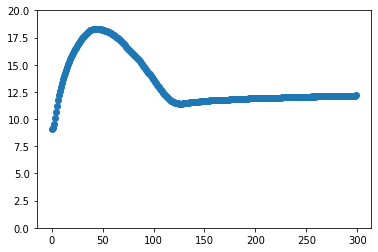

In [ ]:
########### Without warm start ################
###### ||(W_true)^(\dagger) - W_autoenc||^2_F #### \dagger: pseudoinv
for width in width_list:
  #print(Diff_weight[str(width)])
  plt.scatter( range(num_epochs), Diff_weight[str(width)+str(N_samples) ] )
  plt.ylim(0,20)

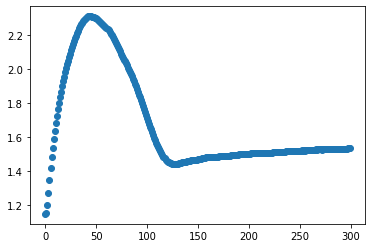

In [ ]:
#### Specific width

for width in width_list:
  ### relative ###
  Rel_list=[el/np.linalg.norm( np.linalg.pinv(K) ) for el in\
                              Diff_weight[str(width)+str(N_samples)] ]

  plt.scatter( range(num_epochs), Rel_list )

In [ ]:
[el for el in [1,2,3,4]]

[1, 2, 3, 4]

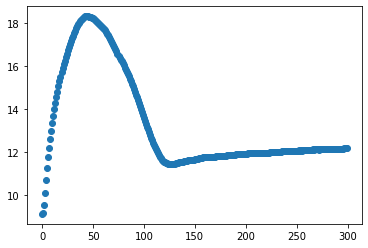

In [ ]:
####### With warm start ###############

for width in width_list:
  #print(Diff_weight[str(width)])
  plt.scatter( range(num_epochs), Diff_weight[str(width)+str(N_samples)] )
  #plt.ylim(0,20)

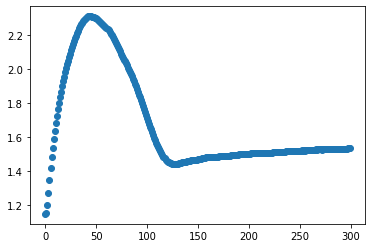

In [ ]:

for width in width_list:
  ### relative ###
  Rel_list=[el/np.linalg.norm( np.linalg.pinv(K) ) for el in\
                              Diff_weight[str(width)+str(N_samples)] ]

  plt.scatter( range(num_epochs), Rel_list )

  

# Options:
We can plot the direct difference. Relative version i.e. norm( Wf-Wi )/ norm(Wi).
We can have a) no warm start b) warm start at the encoder layer only c) warm start at both encoder and decoder 

In [ ]:
print( dictionary.shape )
print( model.encoder[0].weight.data.shape )
print( model.decoder[0] )


(20, 15)
torch.Size([15, 20])
Linear(in_features=15, out_features=20, bias=True)


In [ ]:
recon_list=[]
for (img) in trainloader:
  # get the inputs
  img=img.float()
  img=img.reshape(-1,input_dim)#.double() 
  
  #print(img.shape)
  recon=model(img)
  recon_list.append(recon)


In [ ]:
print(recon_list)

[tensor([[5.2223e-09, 1.0473e-03, 6.3616e-02,  ..., 4.8916e-03, 4.7179e-05,
         1.0940e-02],
        [4.1678e-12, 4.3593e-02, 9.6512e-03,  ..., 8.9528e-01, 1.3945e-02,
         6.2824e-03],
        [6.3462e-12, 3.4700e-03, 2.3757e-02,  ..., 5.6316e-01, 2.4644e-02,
         1.2747e-03],
        ...,
        [3.5949e-15, 1.4552e-01, 5.2046e-04,  ..., 1.9263e-03, 1.1050e-01,
         7.1528e-03],
        [1.9526e-19, 4.1924e-05, 1.3036e-02,  ..., 2.8453e-04, 5.2392e-04,
         2.3929e-05],
        [1.9892e-01, 5.7374e-02, 3.0916e-03,  ..., 2.0339e-01, 3.6082e-02,
         3.0031e-02]], grad_fn=<SigmoidBackward0>)]


In [ ]:
X_auto=recon_list[0].reshape(input_dim,-1).detach().numpy()
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

ValueError: ignored

In [ ]:
# print('Distance from X',np.mean(np.sum((X_auto - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))
# print('Distance from X_hat',np.mean(np.sum((X_auto - X_hat) ** 2, axis=1) / np.sum(X ** 2, axis=1)))


In [ ]:
# print('Distance from D',np.linalg.norm( (model.encoder[0].weight.data.numpy()- dictionary.T) )/
#       np.linalg.norm(dictionary.T) )


In [ ]:
print(X.shape)

(20, 1000)


# NTK


In [ ]:

# define a couple of helper functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
def relu(x):
    return x*(x>0)
def deriv_relu(x):
    return (x>0).astype('double')

def loss(y_,y):
    return .5*norm(y_-y,2)**2
def deriv_loss(y_,y): 
    return (y_-y)

def compute_relchange(w0,wt):    
    return (norm(wt.flatten())-norm(w0.flatten()))/norm(w0.flatten())

no b

In [ ]:
# scan through low n_comp -> high
# plot the difference in loss between rand and dict initialization
# for low samples/components is lazy learning more true around rand or dict initialization
# scan through n_samples 
# n_comp - default 15/20
# n_samples - default 1000

# loss with sparsity instead of l2 norm

# define a few parameters 


def NTK(dictionary, randinit):
  if randinit:
    #scale_w1 = 1
    #scale_w2 = 1
    w_hx = scale_w1*np.random.randn(n_hidden,n_in)
    w_yh = scale_w2*np.random.randn(n_out,n_hidden)
  else:
    w_hx = dictionary.T
    w_yh = np.linalg.pinv(dictionary.T)
  w_hx_0 = w_hx 
  w_yh_0 = w_yh
  # cycle through datapoints and collect gradients
  all_gradients = np.empty((n_hidden*(n_in+n_out),X.shape[1]))
  diff = 0
  for ii in range(X.shape[1]):
      xi = X[:,ii].reshape(n_in,1)
      yi = X[:,ii].reshape(n_in,1)
      
      # forward pass 
      # n_in -> n
      h_1 = w_hx.dot(xi)
      h_2 = relu(h_1)
      diff += np.linalg.norm(h_2 - code) 
      # n -> n_in
      h_3 = w_yh.dot(h_2)
      y_ = sigmoid(h_3)
      l = loss(y_, yi)
      
      # partial derivatives
      
      dLoss_Yh = - (np.divide(yi, y_ ) - np.divide(1 - yi, 1 - y_))  
      dLoss_Z2 = dLoss_Yh * deriv_sigmoid(h_3)    
      dLoss_A1 = np.dot(w_yh.T,dLoss_Z2)
      dLoss_W2 = 1./h_2.shape[1] * np.dot(dLoss_Z2,h_2.T)
      #dLoss_b2 = 1./h_2.shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 

      dLoss_Z1 = dLoss_A1 * deriv_relu(h_1)        
      dLoss_A0 = np.dot(w_hx.T,dLoss_Z1)
      dLoss_W1 = 1./xi.shape[1] * np.dot(dLoss_Z1,xi.T)
      #dLoss_b1 = 1./xi.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))
      # add to collection
      grad_vect = np.concatenate((dLoss_W1.flatten(),dLoss_W2.flatten()))
      all_gradients[:,ii] = grad_vect
  #print(all_gradients.shape)
  diff/=X.shape[1]
  diff/=np.linalg.norm(code)
  #print('diff',diff)
  # compute the NTK (dot product of gradients)
  H = np.dot(all_gradients.T,all_gradients)
  return H, w_hx, w_yh


# plot the ntk
'''
plt.figure(figsize=(21,15))
plt.plot(np.diag(H))
plt.title('Neural Tangent Kernel')
'''     

"\nplt.figure(figsize=(21,15))\nplt.plot(np.diag(H))\nplt.title('Neural Tangent Kernel')\n"

vary n_comp, n_samples and input dim keeping track of loss after a small step

run plots from blog

ntk gan

fraction of nodes firing remains a constant 

weight matrix visualization - large node regime 

gabor patches

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


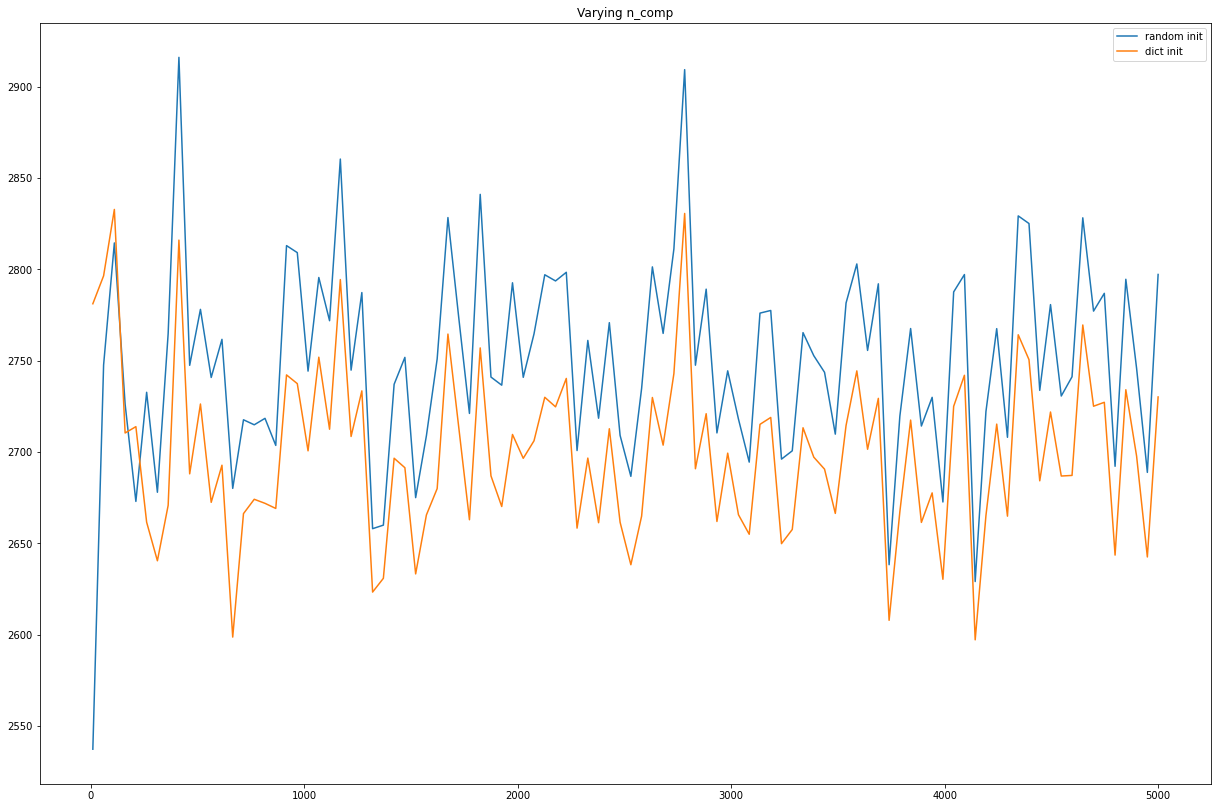

In [ ]:
################# params #########################
n_nonzero_coefs=10
n_comp=15
n_samples=1000
input_dim=20
#####################################################

num = 100

losses = np.zeros((2,num))
stepped_losses = np.zeros((2,num))

norm_x = np.zeros((num))
i=0
for comp in np.linspace(10,5000,num):
  comp = int(comp)
  X, dictionary, code = make_sparse_coded_signal(
  n_samples=n_samples, n_components=comp, n_features=input_dim, \
  n_nonzero_coefs=n_nonzero_coefs,random_state=42,
  )
  temp = np.random.randn(dictionary.shape[0], dictionary.shape[1])
  norm_x[i] = np.linalg.norm(X-temp.dot(code))

  n_in = X.shape[0]
  n_hidden = comp
  n_out = X.shape[0]

  scale_w1 = 0.5# 1/np.sqrt(2)
  scale_w2 = 1/n_hidden 

  H_rand, w_hx_r, w_yh_r = NTK(dictionary, True)
  H_rand = np.nan_to_num(H_rand, nan=0)
  H_dict, w_hx_d, w_yh_d = NTK(dictionary, False)
  y_ = sigmoid(w_yh_r.dot(relu(w_hx_r.dot(X))))
  t = 0.01
  losses[0,i] = loss(y_,X)
  u = np.dot(X - y_,expm(-H_rand*t))   
  yh = X-u
  stepped_losses[0,i] = loss(X,yh)

  y_ = sigmoid(w_yh_d.dot(relu(w_hx_d.dot(X))))
  losses[1,i] = loss(y_,X)
  u = np.dot(X - y_,expm(-H_dict*t))   
  yh = X-u
  stepped_losses[1,i] = loss(X,yh)

  i+=1
  if i %5 == 0:
    print(i)
plt.figure(figsize=(21,14))
plt.plot(np.linspace(10,5000,num), losses[0,:], label = "random init")
plt.plot(np.linspace(10,5000,num), losses[1,:], label = "dict init")
plt.legend()
plt.title("Varying n_comp")

plt.show()



[[1.85562112e+02 3.64288666e+01 1.57602814e+01 8.12802855e+00
  7.49098108e+00 3.64462366e+00 4.52325877e+00 2.39912339e+00
  1.86822281e+00 1.72046627e+00 1.14674601e+00 8.20741579e-01
  1.03765745e+00 9.11346612e-01 5.68802339e-01 9.31878778e-01
  5.16330850e-01 4.46681215e-01 4.37155398e-01 3.99582897e-01
  3.50274047e-01 2.16786978e-01 2.67973363e-01 2.09380571e-01
  1.24120467e-01 3.63109658e-01 1.47073671e-01 2.03495954e-01
  2.49045636e-01 1.02975220e-01 1.46562812e-01 2.09018912e-01
  1.88409015e-01 3.91165276e-01 7.41888602e-02 5.63416084e-01
  2.83314638e-01 1.23391977e-01 4.35354291e-02 2.90682322e-02
  5.96189536e-02 3.79376374e-02 1.62273414e-01 1.07339848e-02
  8.95474219e-02 2.89150983e-02 6.67377700e-02 1.49496833e-02
  3.72732455e-02 7.09785516e-02 2.41409016e-02 1.19092531e-02
  3.63408064e-02 6.84625743e-03 1.58619928e-02 1.79260280e-02
  9.32805582e-03 2.80548605e-02 8.14701093e-02 3.70091058e-03
  1.01530525e-02 7.19496096e-03 3.18059392e-03 2.98168399e-02
  1.6137

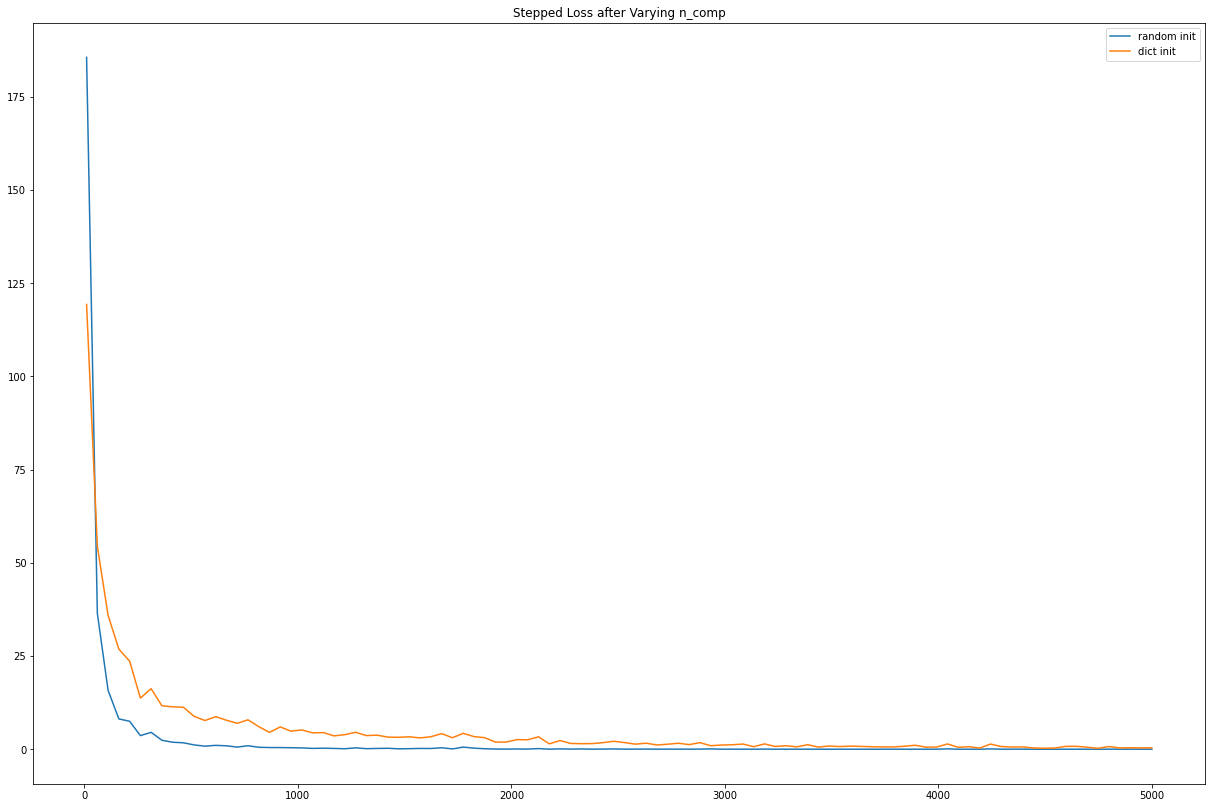

In [ ]:
plt.figure(figsize=(21,14))
plt.plot(np.linspace(10,5000,num), stepped_losses[0,:], label = "random init")
plt.plot(np.linspace(10,5000,num), stepped_losses[1,:], label = "dict init")
plt.legend()
plt.title("Stepped Loss after Varying n_comp")
plt.show()

0
82


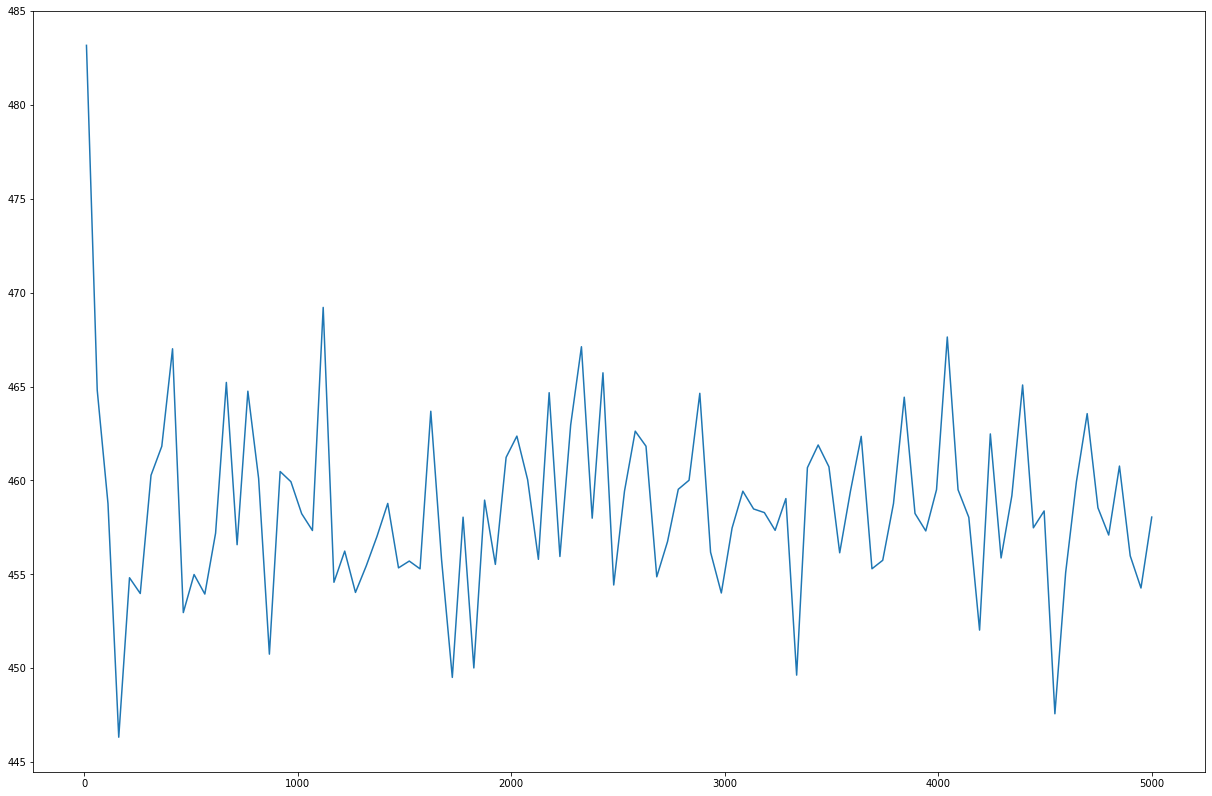

In [ ]:
print(np.argmin(losses[0,:]))
print(np.argmin(losses[1,:]))
plt.figure(figsize = (21,14))
plt.plot(np.linspace(10,5000,num), norm_x)
plt.show()

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


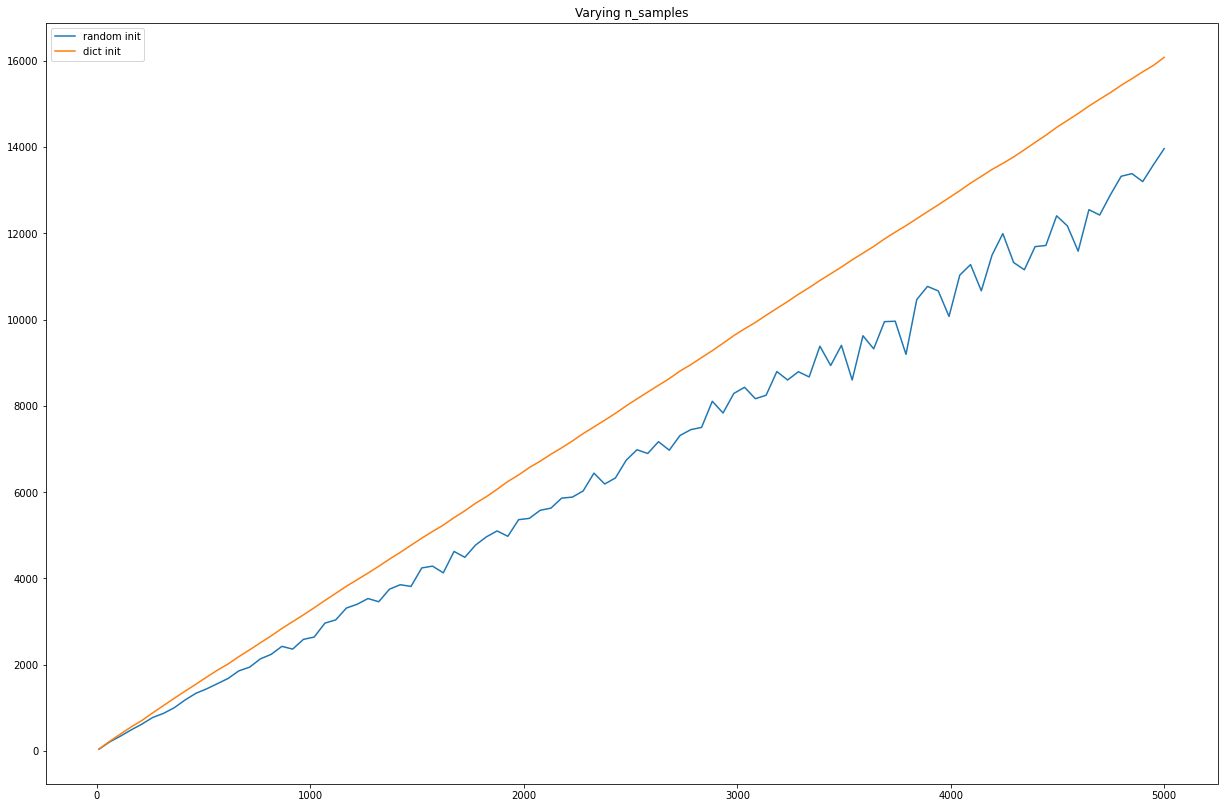

In [ ]:
################# params #########################
n_nonzero_coefs=10
n_comp=15
n_samples=1000
input_dim=20
#####################################################
'''
X, dictionary, code = make_sparse_coded_signal(
n_samples=n_samples, n_components=n_comp, n_features=input_dim, \
n_nonzero_coefs=n_nonzero_coefs,random_state=42,
)
'''



num = 100

losses = np.zeros((2,num))
stepped_losses = np.zeros((2,num))
norm_x = np.zeros((num))
i=0
for samples in np.linspace(10,5000,num):
  samples = int(samples)
  X, dictionary, code = make_sparse_coded_signal(
  n_samples=samples, n_components=n_comp, n_features=input_dim, \
  n_nonzero_coefs=n_nonzero_coefs,random_state=42,
  )
  temp = np.random.randn(dictionary.shape[0], dictionary.shape[1])
  norm_x[i] = np.linalg.norm(X-temp.dot(code))

  n_in = X.shape[0]
  n_hidden = n_comp
  n_out = X.shape[0]
  scale_w1 = 0.5# 1/np.sqrt(2)
  scale_w2 = 1/n_hidden 

  H_rand, w_hx_r, w_yh_r = NTK(dictionary, True)
  H_rand = np.nan_to_num(H_rand, nan=0)
  H_dict, w_hx_d, w_yh_d = NTK(dictionary, False)
  y_ = sigmoid(w_yh_r.dot(relu(w_hx_r.dot(X))))
  t = 0.01
  losses[0,i] = loss(y_,X)
  u = np.dot(X - y_,expm(-H_rand*t))   
  yh = X-u
  stepped_losses[0,i] = loss(X,yh)

  y_ = sigmoid(w_yh_d.dot(relu(w_hx_d.dot(X))))
  losses[1,i] = loss(y_,X)
  u = np.dot(X - y_,expm(-H_dict*t))   
  yh = X-u
  stepped_losses[1,i] = loss(X,yh)

  i+=1
  if i %5 == 0:
    print(i)
plt.figure(figsize=(21,14))
plt.plot(np.linspace(10,5000,num), losses[0,:], label = "random init")
plt.plot(np.linspace(10,5000,num), losses[1,:], label = "dict init")
plt.legend()
plt.title("Varying n_samples")

plt.show()


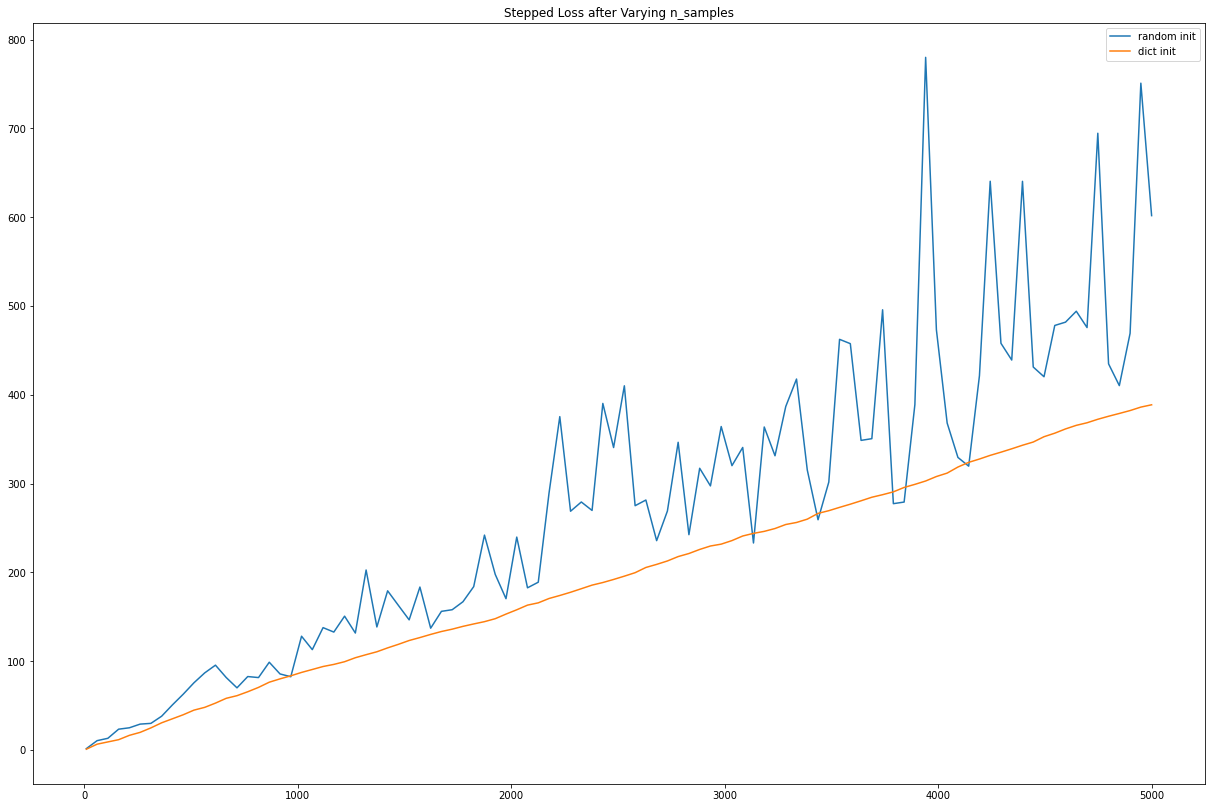

In [ ]:
plt.figure(figsize=(21,14))
plt.plot(np.linspace(10,5000,num), stepped_losses[0,:], label = "random init")
plt.plot(np.linspace(10,5000,num), stepped_losses[1,:], label = "dict init")
plt.legend()
plt.title("Stepped Loss after Varying n_samples")
plt.show()

0
0


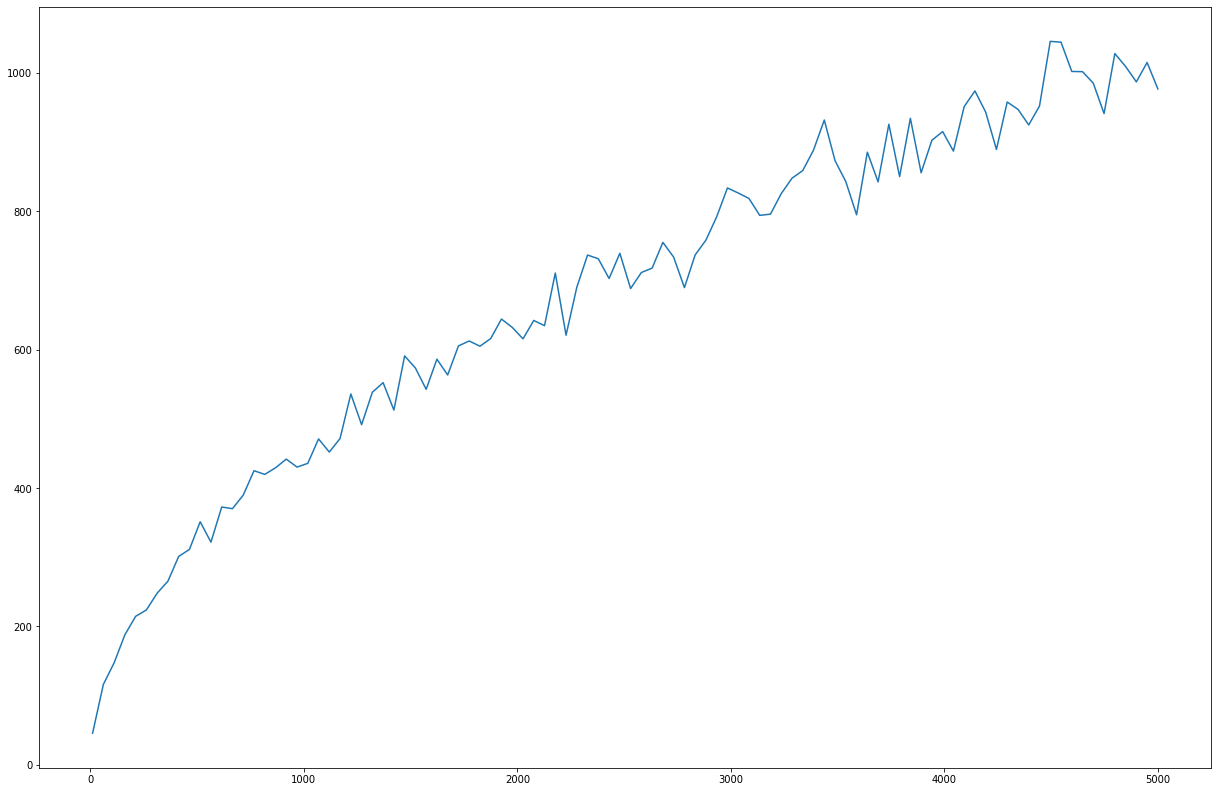

In [ ]:
print(np.argmin(losses[0,:]))
print(np.argmin(losses[1,:]))
plt.figure(figsize=(21,14))
plt.plot(np.linspace(10,5000,num), norm_x)
plt.show()

1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


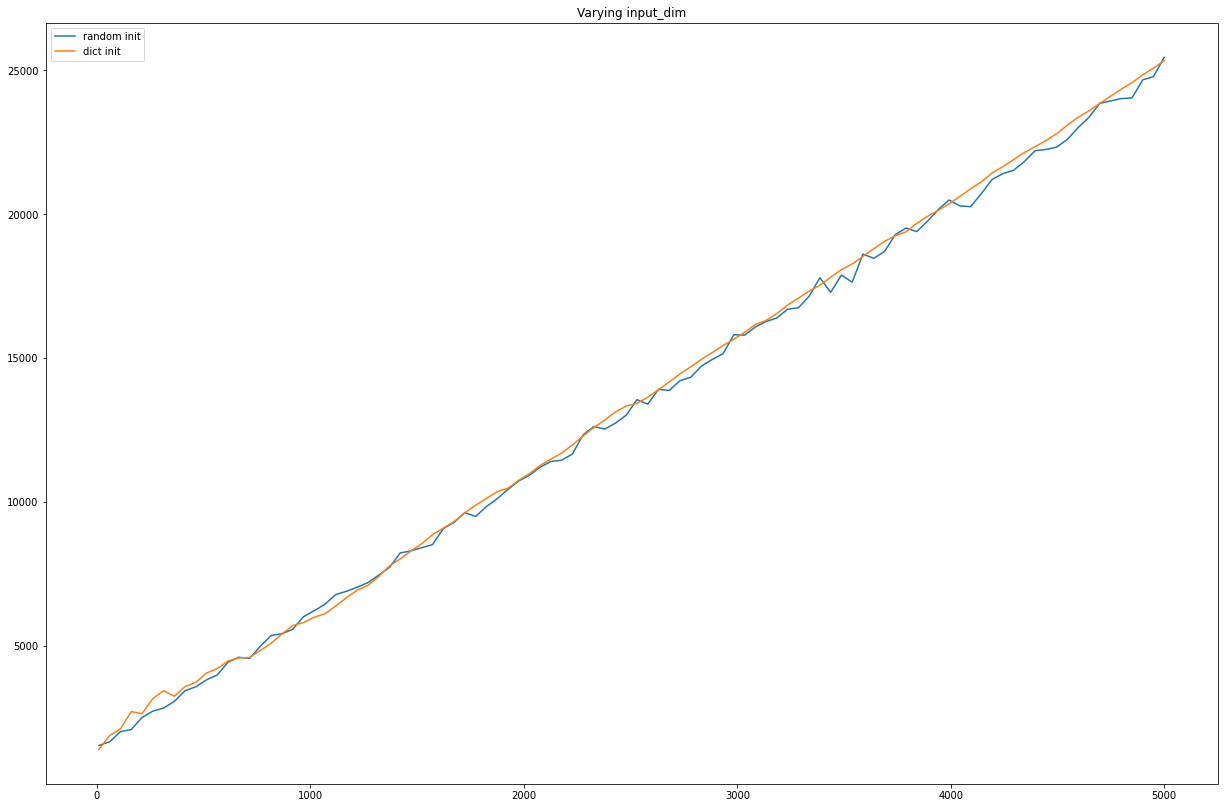

In [ ]:
################# params #########################
n_nonzero_coefs=10
n_comp=15
n_samples=1000
input_dim=20
#####################################################

num = 100

losses = np.zeros((2,num))
norm_x = np.zeros((num))
i=0
for i_dim in np.linspace(10,200,num):
  i_dim = int(i_dim)
  X, dictionary, code = make_sparse_coded_signal(
  n_samples=n_samples, n_components=n_comp, n_features=i_dim, \
  n_nonzero_coefs=n_nonzero_coefs,random_state=42,
  )
  temp = np.random.randn(dictionary.shape[0], dictionary.shape[1])
  norm_x[i] = np.linalg.norm(X-temp.dot(code))

  n_in = X.shape[0]
  n_hidden = n_comp
  n_out = X.shape[0]

  scale_w1 = 0.5# 1/np.sqrt(2)
  scale_w2 = 1/n_hidden 

  H_rand, w_hx_r, w_yh_r = NTK(dictionary, True)
  H_rand = np.nan_to_num(H_rand, nan=0)
  H_dict, w_hx_d, w_yh_d = NTK(dictionary, False)
  y_ = sigmoid(w_yh_r.dot(relu(w_hx_r.dot(X))))
  
  losses[0,i] = loss(y_,X)
  y_ = sigmoid(w_yh_d.dot(relu(w_hx_d.dot(X))))
  losses[1,i] = loss(y_,X)
  i+=1
  print(i)
plt.figure(figsize=(21,14))
plt.plot(np.linspace(10,5000,num), losses[0,:], label = "random init")
plt.plot(np.linspace(10,5000,num), losses[1,:], label = "dict init")
plt.legend()
plt.title("Varying input_dim")

plt.show()


0
0


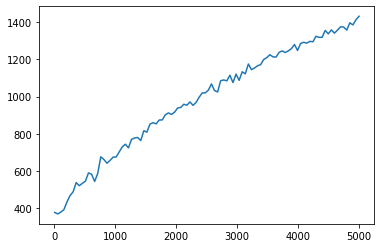

In [ ]:
print(np.argmin(losses[0,:]))
print(np.argmin(losses[1,:]))
plt.plot(np.linspace(10,5000,num), norm_x)


In [ ]:
print(np.linalg.norm(X-dictionary.dot(code)))

temp = np.random.randn(dictionary.shape[0], dictionary.shape[1])
print(np.linalg.norm(X-temp.dot(code)))

H_rand, w_hx_r, w_yh_r, b1_r, b2_r = NTK(dictionary, True)
H_dict, w_hx_d, w_yh_d, b1_d, b2_d = NTK(dictionary, False)

H_rand = np.nan_to_num(H_rand, nan=0)

0.0
141.84382838173528


NameError: ignored

In [ ]:
def plot_loss(H, w_hx, w_yh, num = 10):
  # compute difference between labels and network output at initialisation
  y_ = sigmoid(w_yh.dot(relu(w_hx.dot(X))))
  print(loss(y_,X))
  u0 = X - y_
  # evaluate the loss for each time point
  ts = np.linspace(0,0.5,num=num)
  #yh = np.empty((500,X.shape[0]))
  l = np.empty((num))
  yh = np.empty((num, X.shape[0], X.shape[1]))
  for ii in range(ts.shape[0]):
      t = ts[ii]
      # matrix exponential used to compute solution to differential equation x(t) = x_0 * exp(t*A)
      u = np.dot(u0,expm(-H*t))   
      yh[ii] = X-u
      l[ii] = loss(X,yh[ii])
  plt.plot(ts, l, color = 'k')
  plt.show()

  # scan through low n_comp -> high
# plot the difference in loss between rand and dict initialization
# for low samples/components is lazy learning more true around rand or dict initialization
# scan through n_samples 
# n_comp - default 15/20
# n_samples - default 1000

b


In [ ]:
################# params #########################
n_nonzero_coefs=10
n_comp=15
n_samples=100
input_dim=20
#####################################################
X, dictionary, code = make_sparse_coded_signal(
n_samples=n_samples, n_components=n_comp, n_features=input_dim, \
n_nonzero_coefs=n_nonzero_coefs,random_state=42,

)
# define a few parameters 
n_in = X.shape[0]
n_hidden = n_comp
n_out = X.shape[0]
scale_w1 = 0.5# 1/np.sqrt(2)
scale_w2 = 1/n_hidden 

# init weights:



# store init weights


def NTK(dictionary, randinit):
  if randinit:
    #scale_w1 = 1
    #scale_w2 = 1
    w_hx = scale_w1*np.random.randn(n_hidden,n_in)
    w_yh = scale_w2*np.random.randn(n_out,n_hidden)
  else:
    w_hx = dictionary.T
    w_yh = np.linalg.pinv(dictionary.T)
  w_hx_0 = w_hx 
  w_yh_0 = w_yh
  b1 = np.zeros((n_hidden, 1))
  b2 = np.zeros((n_in, 1))
  # cycle through datapoints and collect gradients
  all_gradients = np.empty((n_hidden*(n_in+n_out+1)+20,X.shape[1]))
  diff = 0
  for ii in range(X.shape[1]):
      xi = X[:,ii].reshape(n_in,1)
      yi = X[:,ii].reshape(n_in,1)
      
      # forward pass 
      # n_in -> n
      h_1 = w_hx.dot(xi) + b1
      h_2 = relu(h_1)
      diff += np.linalg.norm(h_2 - code) 
      # n -> n_in
      h_3 = w_yh.dot(h_2) + b2
      y_ = sigmoid(h_3)
      l = loss(y_, yi)
      
      # partial derivatives
      
      dLoss_Yh = - (np.divide(yi, y_ ) - np.divide(1 - yi, 1 - y_))  
      dLoss_Z2 = dLoss_Yh * deriv_sigmoid(h_3)    
      dLoss_A1 = np.dot(w_yh.T,dLoss_Z2)
      dLoss_W2 = 1./h_2.shape[1] * np.dot(dLoss_Z2,h_2.T)
      dLoss_b2 = 1./h_2.shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 

      dLoss_Z1 = dLoss_A1 * deriv_relu(h_1)        
      dLoss_A0 = np.dot(w_hx.T,dLoss_Z1)
      dLoss_W1 = 1./xi.shape[1] * np.dot(dLoss_Z1,xi.T)
      dLoss_b1 = 1./xi.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))
      # add to collection
      grad_vect = np.concatenate((dLoss_W1.flatten(),dLoss_W2.flatten(), dLoss_b1.flatten(), dLoss_b2.flatten()))
      all_gradients[:,ii] = grad_vect
  print(all_gradients.shape)
  diff/=X.shape[1]
  diff/=np.linalg.norm(code)
  print('diff',diff)
  # compute the NTK (dot product of gradients)
  H = np.dot(all_gradients.T,all_gradients)
  return H, w_hx, w_yh, b1, b2

H_rand, w_hx_r, w_yh_r, b1_r, b2_r = NTK(dictionary, True)
H_dict, w_hx_d, w_yh_d, b1_d, b2_d = NTK(dictionary, False)

H_rand = np.nan_to_num(H_rand, nan=0)

# plot the ntk
'''
plt.figure(figsize=(21,15))
plt.plot(np.diag(H))
plt.title('Neural Tangent Kernel')
'''     

(635, 1000)
diff 1.713743411910439
(635, 1000)
diff 1.3438253585016129


"\nplt.figure(figsize=(21,15))\nplt.plot(np.diag(H))\nplt.title('Neural Tangent Kernel')\n"

In [ ]:
print(H_dict.shape)
print(w_hx_r.shape)

(100, 100)
(5000, 20)


In [ ]:
import seaborn as sns

mask = np.zeros_like(H)
# lower triangular with diagonal removed
mask[np.triu_indices_from(mask, k = -1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(21, 15))
    ax = sns.heatmap(H, mask=mask, square=True)

2786.8270228927763


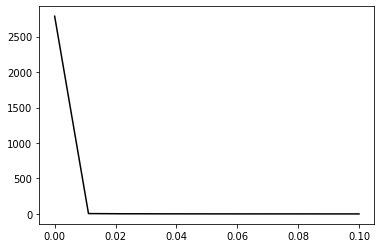

[2.78682702e+03 5.39578036e+00 2.74476844e+00 1.90167630e+00
 1.41808764e+00 1.12063238e+00 9.19322957e-01 7.77993553e-01
 6.75327905e-01 5.95974890e-01]
3261.296198906111


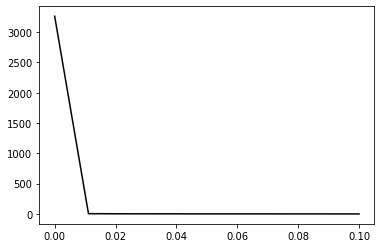

[3.26129620e+03 4.68262368e+00 2.85660936e+00 2.02977388e+00
 1.55785438e+00 1.24927955e+00 1.03048269e+00 8.70971540e-01
 7.67471935e-01 6.91430755e-01]


In [ ]:
def plot_loss(H, w_hx, w_yh, b1, b2, num = 10):
  # compute difference between labels and network output at initialisation
  y_ = sigmoid(w_yh.dot(relu(w_hx.dot(X)+b1))+b2)
  print(loss(y_,X))
  u0 = X - y_
  # evaluate the loss for each time point
  ts = np.linspace(0,0.1,num=num)
  #yh = np.empty((500,X.shape[0]))
  l = np.empty((num))
  yh = np.empty((num, X.shape[0], X.shape[1]))
  for ii in range(ts.shape[0]):
      t = ts[ii]
      # matrix exponential used to compute solution to differential equation x(t) = x_0 * exp(t*A)
      u = np.dot(u0,expm(-H*t))   
      yh[ii] = X-u
      l[ii] = loss(X,yh[ii])
  plt.plot(ts, l, color = 'k')
  plt.show()
  print(l)


plot_loss(H_rand, w_hx_r, w_yh_r, b1_r, b2_r, 10)
plot_loss(H_dict, w_hx_d, w_yh_d, b1_d, b2_d, 10)

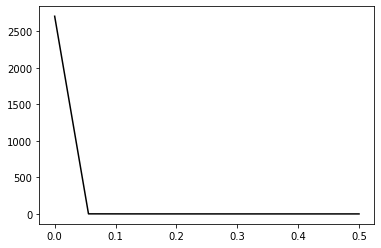

In [ ]:

plt.plot(ts,l,color='k')


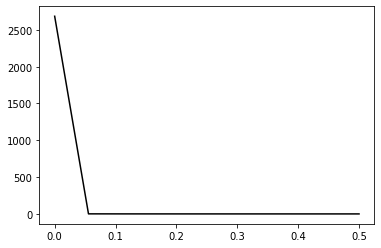

In [ ]:
# 
plt.plot(ts,l,color='k')


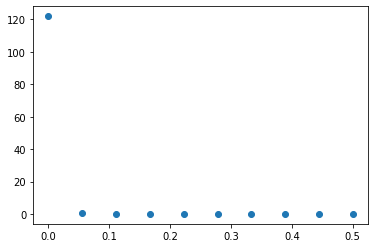

In [ ]:
plt.scatter(ts,l)

In [ ]:
print(u0)
print(u0.shape)
print(w_yh.shape)
print(w_hx.shape)
print(dictionary.shape)

[[-9.45120052e-01 -4.97595641e-01 -8.57263455e-01  3.73944239e-01
  -1.70913861e-01 -5.56690439e-01 -3.51666568e-01 -1.97929570e-01
  -1.64564549e-01 -5.67261678e-01 -6.21481257e-01 -7.51998958e-02
  -3.73826801e-01 -7.86109452e-01 -6.16955782e-01 -1.52262398e+00
  -6.09169363e-01 -4.68428605e-01 -5.94210496e-01 -7.88077177e-01
   3.16102727e-01 -7.79558387e-01 -1.06247927e+00 -1.59214430e+00
  -2.96750914e-01  4.45880496e-01 -1.25761277e+00 -3.24393108e-01
  -1.39663044e+00 -7.17141728e-01 -6.65604066e-01  1.39425008e-01
  -9.74044212e-01 -1.27286530e+00 -9.30542136e-01  2.67817756e-01
  -7.27141496e-01 -1.38304947e-01  1.82723485e-01  1.74757647e-01]
 [ 1.14308876e-01  5.49730932e-01  1.58010198e-01 -1.90610205e-01
  -2.46171710e+00 -2.12303963e-01 -6.02869341e-01  4.82539679e-01
  -5.40041336e-02 -4.94909593e-01 -5.76048911e-01  2.09334269e-01
   1.00776328e-01 -1.47813824e+00 -9.06726888e-02 -5.32311027e-02
   3.71654165e-01  8.79829413e-02  5.19539248e-01  2.73918003e-01
  -3.1195

In [ ]:
print(np.linalg.norm( w_hx.T - dictionary))
print(np.linalg.norm( w_yh - dictionary))

print(np.linalg.norm( w_hx_0.T - dictionary))
print(np.linalg.norm( w_yh_0 - dictionary))

9.456221309070791
3.924524944176111
9.456221309070791
3.924524944176111


In [ ]:
print(np.linalg.norm( w_hx.T - dictionary))
print(np.linalg.norm( w_yh - dictionary))

print(np.linalg.norm( w_hx_0.T - dictionary))
print(np.linalg.norm( w_yh_0 - dictionary))

0.0
4.02839059928055
0.0
4.02839059928055


In [ ]:
print(np.linalg.norm( w_hx.T - dictionary))
print(np.linalg.norm( w_yh - dictionary))

print(np.linalg.norm( w_hx_0.T - dictionary))
print(np.linalg.norm( w_yh_0 - np.linalg.pinv(dictionary.T)))

0.0
2.892073130780037
0.0
0.0


Text(0.5, 1.0, 'Neural Tangent Kernel')

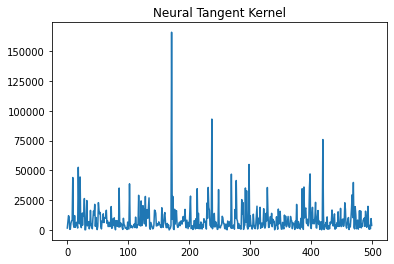

In [ ]:
# define a few parameters 
n_in = X.shape[0]
n_hidden = 500
n_out = X.shape[0]
scale_w1 = 0.5# 1/np.sqrt(2)
scale_w2 = 1/n_hidden 
# init weights:
w_hx = scale_w1*np.random.randn(n_hidden,n_in)
w_yh = scale_w2*np.random.randn(n_out,n_hidden)

# store init weights
w_hx_0 = w_hx 
w_yh_0 = w_yh

# cycle through datapoints and collect gradients
all_gradients = np.empty((n_hidden*(n_in+n_out),X.shape[1]))
for ii in range(X.shape[1]):
    xi = X[:,ii].reshape(n_in,1)
    yi = X[:,ii].reshape(n_in,1)
    
    # forward pass 
    h_in = w_hx.dot(xi)
    h_out = relu(h_in)
    y_ = w_yh.dot(h_out)

    l = loss(yi,y_)
    # partial derivatives
    dl_dy = deriv_loss(y_,yi)
    dy_dh = w_yh 
    dy_dw = h_out
    dho_dhi = deriv_relu(h_in)
    dhi_dw = xi
    # chain rule fun:
    dl_dwyh = dl_dy.dot(dy_dw.T)
    dl_dwhx = (dl_dy.T.dot(dy_dh)*dho_dhi.T).T.dot(dhi_dw.T)    
    # add to collection
    grad_vect = np.concatenate((dl_dwyh.flatten(),dl_dwhx.flatten()))
    all_gradients[:,ii] = grad_vect
# compute the NTK (dot product of gradients)
H_2 = np.dot(all_gradients.T,all_gradients)

# plot the ntk
plt.figure()
plt.plot(np.diag(H_2))
plt.title('Neural Tangent Kernel')

In [ ]:
# compute difference between labels and network output at initialisation
y_ = w_yh.dot(relu(w_hx.dot(X)))
u0 = X - y_

# evaluate the loss for each time point
ts = np.linspace(0,0.5,num=500)
#yh = np.empty((500,X.shape[0]))
l = np.empty((500))
for ii in range(ts.shape[0]):
    t = ts[ii]
    # matrix exponential used to compute solution to differential equation x(t) = x_0 * exp(t*A)
    u = np.dot(u0,expm(-H_2*t))    
    yh = X-u
    
    l[ii] = loss(X,yh)
    

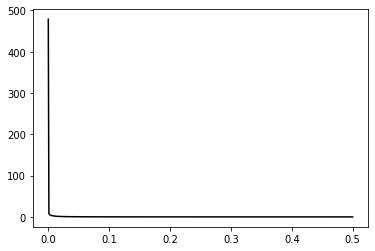

In [ ]:
plt.plot(ts,l,color='k')
print(l)